<a href="https://colab.research.google.com/github/Saumya-1802/House-Price-Prediction/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y xgboost
!pip install xgboost==2.1.4

Found existing installation: xgboost 2.1.4
Uninstalling xgboost-2.1.4:
  Successfully uninstalled xgboost-2.1.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 5.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import metrics
import matplotlib.pyplot as plt
import xgboost as xgb  # Make sure this is here

In [3]:
# Load Ames Housing dataset
housing = fetch_openml(name="house_prices", as_frame=True)
df = housing.frame


In [4]:
X = df.drop(columns=['SalePrice'])
Y = df['SalePrice']

In [5]:
X = pd.get_dummies(X, drop_first=True)

In [6]:
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)


In [8]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

In [9]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 4,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 1,
    'lambda': 1,
    'seed': 2
}


In [10]:
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=False
)

In [11]:
train_preds = bst.predict(dtrain)
test_preds = bst.predict(dtest)

In [15]:
# Evaluation function
def print_metrics(true, preds, dataset_name="Dataset"):
    r2 = metrics.r2_score(true, preds)
    mae = metrics.mean_absolute_error(true, preds)
    mse = metrics.mean_squared_error(true, preds)
    rmse = np.sqrt(mse)
    print(f"{dataset_name} R²: {r2:.4f}")
    print(f"{dataset_name} MAE: {mae:.4f}")
    print(f"{dataset_name} MSE: {mse:.4f}")
    print(f"{dataset_name} RMSE: {rmse:.4f}")
    print("-" * 40)

In [16]:
# Print metrics for training and test sets
print_metrics(Y_train, train_preds, "Training")
print_metrics(Y_test, test_preds, "Test")

Training R²: 0.9841
Training MAE: 7430.8853
Training MSE: 99127312.0000
Training RMSE: 9956.2700
----------------------------------------
Test R²: 0.9128
Test MAE: 16349.1299
Test MSE: 577145472.0000
Test RMSE: 24023.8521
----------------------------------------


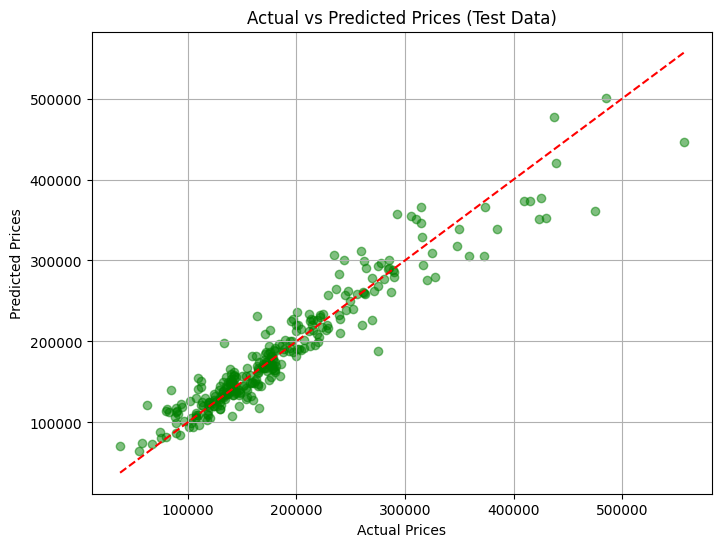

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, test_preds, alpha=0.5, color='green')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices (Test Data)")
plt.grid(True)
plt.show()

In [19]:
import seaborn as sns

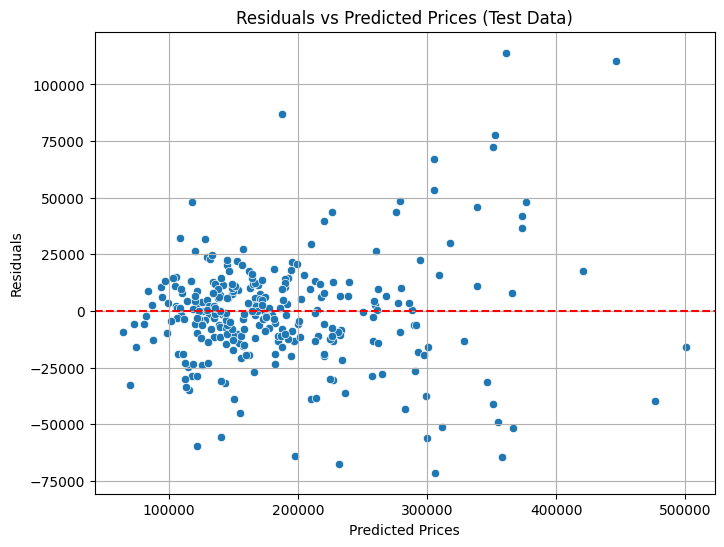

In [20]:
# Residuals plot (Test)
residuals = Y_test - test_preds
plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_preds, y=residuals)
plt.axhline(0, linestyle='--', color='r')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Prices (Test Data)")
plt.grid(True)
plt.show()

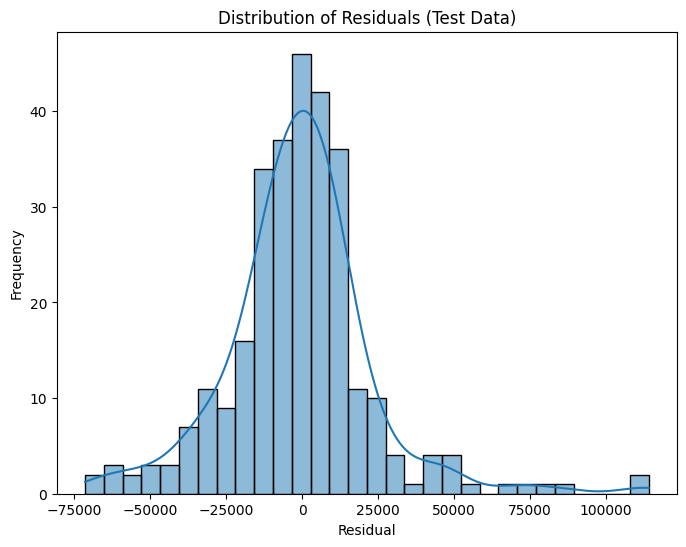

In [21]:
# Distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals (Test Data)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()
